# Processing and Analyzing ADV Data with DOLfYN
To get started first install the DOlfYN library and import the DOLfYN ADV advanced programming interface (API)

In [1]:
!pip install dolfyn

In [2]:
# !pip install mpld3

In [3]:
# !pip install bokeh

In [4]:
import numpy as np
import matplotlib

In [5]:
import dolfyn.adv.api as avm
import dolfyn.adv.turbulence as turb

In [6]:
matplotlib.use("Qt5Agg")
from PyQt5 import QtCore
from PyQt5.QtWidgets import QApplication, QMainWindow, QMenu, QVBoxLayout, QSizePolicy, QMessageBox, QWidget

Import matplotlib tools for plotting the data:

In [7]:
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
import matplotlib.pyplot as plt
import matplotlib.dates as dt
import matplotlib.ticker as mtick
import os.path

Import Bokeh tools for plotting interactive data:

In [8]:
# from bokeh.io import curdoc, push_notebook, show, output_notebook
# from bokeh.layouts import row, column
# from bokeh.models import ColumnDataSource, CustomJS, HoverTool, BoxSelectTool
# from bokeh.models.widgets import PreText, Select
# from bokeh.plotting import figure, show

# output_notebook()

Import urllib in case the '.VEC' file has not been downloaded yet. 

In [9]:
import urllib2

## 1. User Specifications

The following inputs are specific to each ADV file and must be customized accordingly:
1. fname- This is the pathway to the raw ADV file.
2. body2head_vec- This is the vector from the ADV head to the body frame, in meters, in the ADV coordinate system.
3. body2head_rotmat- This is the orientation matrix of the ADV head relative to the body. For example, if the head was aligned with the body then this matrix would be the identity matrix.
4. accel_filter- This is the filter to use for motion correction, typically defined as 0.1

In [10]:
fname = '/Users/lillie/turbulence_data/raw_data/TTM01_ADVbottom_NREL01_June2014'
body2head_vec = np.array([9.75, 2, -5.75]) * 0.0254
body2head_rotmat = np.array([[0, 0, -1], [0, -1, 0], [-1, 0, 0]])
accel_filter = 0.1
load_vec = True

## 2. Load the Data File:
The first step is to read the raw ADV data file specified above. If the file does not exist in the above pathway, then the '.VEC' file will be downloaded from the internet. 

In [13]:
%%time
#If the file exists...

#....as an '.h5' file, read it
if os.path.isfile(fname + '.h5'):
    dat_raw = avm.load(fname + '.h5')
#....as a '.VEC' file, save it as an '.h5' and then read it using dolfyn library
elif os.path.isfile(fname + ',VEC'):
    dat_raw = avm.read_nortek(fname + '.VEC')
    dat_raw.save(fname + '.h5')  

# If the file does not exist as either a '.VEC' or '.h5', download it from the internet, save it as a '.h5' file and read it
else:
    file = 'TTM01_ADVbottom_NREL01_June2014.VEC'
    url = 'https://mhkdr.openei.org/files/50/ttm01_ADVbottom_NREL01_June2014.VEC'
    response = urllib2.urlopen(url)
    with open(file, 'wb') as f: 
        f.write(response.read())
    dat_raw = avm.read_nortek(data)
    dat_raw.save(fname + '.h5')   

CPU times: user 1.48 s, sys: 276 ms, total: 1.76 s
Wall time: 4.17 s


In [11]:
# This piece of code is meant to allow the user to select a specific point in the interactive graph below but
# currently it is not working
def onpick(event):
    ind = event.ind
    print('onpick scatter:', ind, np.take(dat_raw.mpltime, ind), np.take(dat_raw.u, ind))

The next block of code defines functions that will enable the raw data to be presented in interactive graphs using a small amount of memory by downsampling the data file. 

In [14]:
# A class that will downsample the data and recompute when zoomed.
class DataDisplayDownsampler(object):
    def __init__(self, xdata, ydata):
        self.origYData = ydata
        self.origXData = xdata
        self.ratio = 5
        self.delta = xdata[-1] - xdata[0]

    def downsample(self, xstart, xend):
        # Very simple downsampling that takes the points within the range
        # and picks every Nth point to display on the graph
        mask = (self.origXData > xstart) & (self.origXData < xend)
        xdata = self.origXData[mask]
        xdata = xdata[::self.ratio]

        ydata = self.origYData[mask]
        ydata = ydata[::self.ratio]

        return xdata, ydata
    
    def update(self, ax):
        # Update the line
        lims = ax.viewLim
        if np.abs(lims.width - self.delta) > 1e-8:
            self.delta = lims.width
            xstart, xend = lims.intervalx
            self.line.set_data(*self.downsample(xstart, xend))
            ax.figure.canvas.draw_idle()
        fig.canvas.mpl_connect('pick_event', onpick)

In [18]:
# Create a downsampling object
d = DataDisplayDownsampler(dat_raw.mpltime, dat_raw.u)

## 3. Cropping and Cleaning the Raw Data:

The raw data file looks has many attributes including the velocity arrays and a time series arrays that can be accessed by the following lines of code. 

In [15]:
dat_raw.u

array([-0.26100001,  4.48500013,  0.91500002, ..., -0.66200006,
        0.41800001, -2.10800004], dtype=float32)

In [16]:
dat_raw.mpltime

time_array([ 735729.33336517,  735729.3333659 ,  735729.33336663, ...,
        735731.33319924,  735731.33319997,  735731.3332007 ])

 However, the raw data file has not been cropped or cleaned. 
 ### Cropping:
 The data taken on the tail ends of the collection period are affected due to the mooring falling to the sea and then again at the end as the mooring, which can be seen in the graph below. This means that the data on the tail ends should be removed when performing our data processing and analysis. In other words, the time period of interest must be adjusted as to not include the poor data. The following code uses a variance threshold to estimate the t_range and then the user can confirm this with an interactive graph below. 

In [18]:
advr = dat_raw
n_bin = 10000
n_fft = 4096
    
# create a TurbBinner object
calculator = turb.TurbBinner(n_bin, advr.fs, n_fft=n_fft)
out = turb.VelBinnerSpec.__call__(calculator, advr)

# perform the average and variance
calculator.do_var(advr, out)
calculator.do_avg(advr, out)

# add the standard deviation
out.add_data('sigma_Uh',
                np.std(calculator.reshape(advr.U_mag), -1, dtype=np.float64) -
                (advr.noise[0] + advr.noise[1]) / 2, 'main')

# define just the u velocity variance
u_var = out.vel_var[0]
# u_vel = out.vel[0]

timeset = []
for i, j in zip(u_var, out.mpltime):
    if i < 1:
        timeset.append(j)

start = timeset[0]
end = timeset[len(timeset)-1]
t_range = [start, end]
# display the output below
t_range

[735729.45367741608, 735731.30576250004]

The output above is the estimated t_range that should be used to crop the data, however, you can use the hover tool and the zoom tool in the interactive graph below to select the start and end indexes of the data range of interest.

<IPython.core.display.Javascript object>


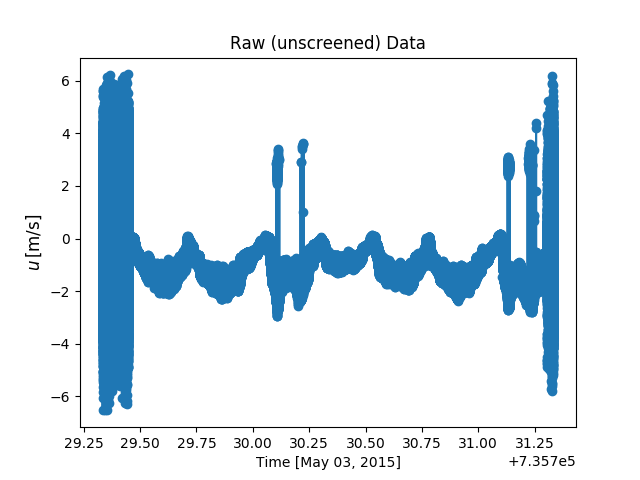

In [19]:
%%time
%matplotlib nbagg
fig, ax = plt.subplots()

# Hook up the line
d.line, = ax.plot(dat_raw.mpltime, dat_raw.u, 'o-')
ax.set_autoscale_on(False)  # Otherwise, infinite loop
# Connect for changing the view limits
ax.callbacks.connect('xlim_changed', d.update)
    
ax.set_ylabel('$u\,\mathrm{[m/s]}$', size='large')
ax.set_xlabel('Time [May 03, 2015]')
ax.set_title('Raw (unscreened) Data')

plt.show()

Below, specify the start and end x values of the data so that it can be cropped. You can use the rectangle select tool to zoom in and determine these values. Be sure to add the number in the lower right corner to the desired value, noting that this value changes as you zoom. The home button will return the figure to its original state. 

Note, if you don't think the t_range needs to be changed then don't run the following cell.

In [20]:
x_start = .00835 + 7.3572944e5
x_end = .304 + 7.35731e5
t_range = [x_start, x_end]
t_range

[735729.44835, 735731.304]

In [32]:
# %%time
# tools = 'wheel_zoom, reset, hover'
# p1 = figure(plot_width=900, plot_height=200, tools=tools)
# p1.line(dat_raw.mpltime, dat_raw.u, color='navy', alpha=0.5)
# t = show(p1, notebook_handle=True)

Now that a t_range has been specified to crop the data, the unscreened/raw data will be plotted under the screened/cropped data for visulization. 

<IPython.core.display.Javascript object>


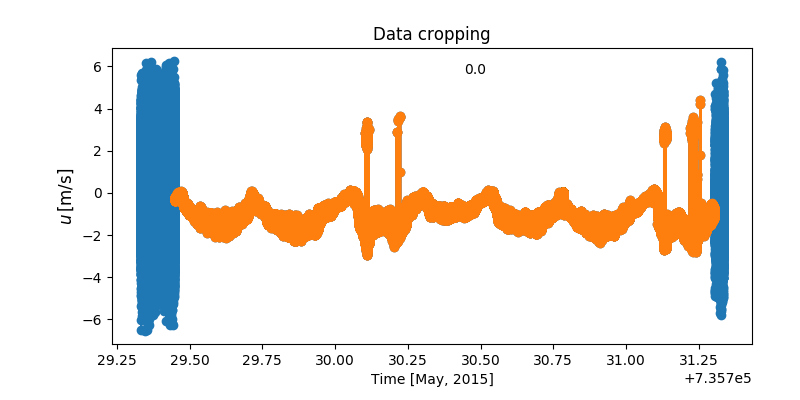

CPU times: user 9.9 s, sys: 1.35 s, total: 11.2 s
Wall time: 15.8 s


In [30]:
%%time
%matplotlib nbagg
fig = plt.figure(1, figsize=[8, 4])
fig.clf()
ax = fig.add_axes([.14, .14, .8, .74])

# Plot the raw (unscreened) data:
d.line, = ax.plot(dat_raw.mpltime, dat_raw.u, 'o-')
ax.set_autoscale_on(False)  # Otherwise, infinite loop
ax.callbacks.connect('xlim_changed', d.update)
    
# Plot the screened data:
t_range_inds = (t_range[0] < dat_raw.mpltime) & (dat_raw.mpltime < t_range[1])
dat_crop = dat_raw.subset(t_range_inds)
dat_crop.props['body2head_vec'] = body2head_vec
dat_crop.props['body2head_rotmat'] = body2head_rotmat
d1 = DataDisplayDownsampler(dat_crop.mpltime, dat_crop.u)

d1.line, = ax.plot(dat_crop.mpltime, dat_crop.u, 'o-', rasterized=True)

bads = np.abs(dat_crop.u - dat_raw.u[t_range_inds])
ax.text(0.55, 0.95, (np.float(sum(bads > 0)) / len(bads) * 100),
            transform=ax.transAxes,
            va='top',
            ha='left',
            )

ax.set_ylabel('$u\,\mathrm{[m/s]}$', size='large')
ax.set_xlabel('Time [May, 2015]')
ax.set_title('Data cropping')

plt.show()

### Cleaning:

Next, the data file must be cleaned from any noise in the signal. The data is cleaned using the Goring+Nikora method. 

In [21]:
%%time
t_range_inds = (t_range[0] < dat_raw.mpltime) & (dat_raw.mpltime < t_range[1])
dat = dat_raw.subset(t_range_inds)
dat.props['body2head_vec'] = body2head_vec
dat.props['body2head_rotmat'] = body2head_rotmat

# Then clean the file using the Goring+Nikora method:
avm.clean.GN2002(dat)
dat_cln = dat.copy()

CPU times: user 49.6 s, sys: 4.5 s, total: 54.1 s
Wall time: 56.4 s


<IPython.core.display.Javascript object>


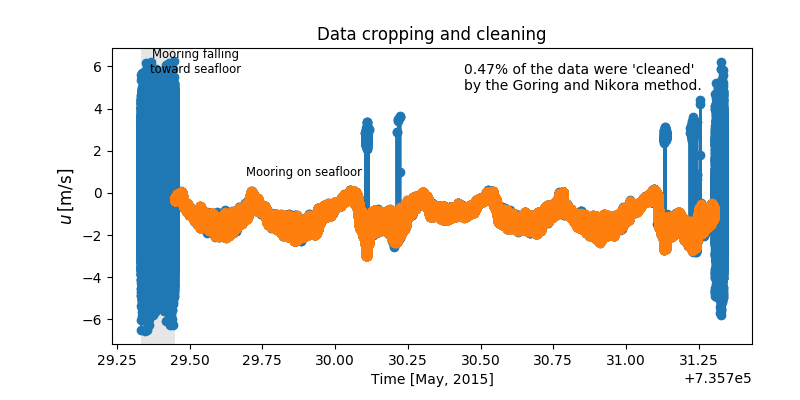

CPU times: user 6.65 s, sys: 227 ms, total: 6.88 s
Wall time: 8.95 s


In [31]:
%%time
%matplotlib nbagg
fig = plt.figure(1, figsize=[8, 4])
fig.clf()
ax = fig.add_axes([.14, .14, .8, .74])

# Plot the raw (unscreened) data:
d.line, = ax.plot(dat_raw.mpltime, dat_raw.u, 'o-')
ax.set_autoscale_on(False)  # Otherwise, infinite loop
ax.callbacks.connect('xlim_changed', d.update)
    

# Plot the screened data:
d2 = DataDisplayDownsampler(dat_crop.mpltime, dat.u)

d1.line, = ax.plot(dat_crop.mpltime, dat.u, 'o-', rasterized=True)

bads = np.abs(dat.u - dat_raw.u[t_range_inds])
ax.text(0.55, 0.95,
        "%0.2f%% of the data were 'cleaned'\nby the Goring and Nikora method."
        % (np.float(sum(bads > 0)) / len(bads) * 100),
        transform=ax.transAxes,
        va='top',
        ha='left',
        )

# Add some annotations:
ax.axvspan(dat_raw.mpltime[0], t_range[0], zorder=-10, facecolor='0.9', edgecolor='none')
ax.text(0.13, 1.0, 'Mooring falling\ntoward seafloor', ha='center', va='top', transform=ax.transAxes, size='small')
ax.text(0.3, 0.6, 'Mooring on seafloor', ha='center', va='top', transform=ax.transAxes, size='small')
ax.annotate('', (0.25, 0.4), (0.4, 0.4), arrowprops=dict(facecolor='black'))


ax.set_ylabel('$u\,\mathrm{[m/s]}$', size='large')
ax.set_xlabel('Time [May, 2015]')
ax.set_title('Data cropping and cleaning')

plt.show()

## 4. Motion Correction:
Next, perform motion correction (including rotation into earth frame) in order to account for the movement of the mooring as tracked by the internal motion unit (IMU). The data must also be rotated into the earth frame for comparison to motion correction. It finally must be roated into the principal axes frame. 

In [24]:
avm.motion.correct_motion(dat_crop, accel_filter)

# Rotate the uncorrected data into the earth frame,
# for comparison to motion correction:
avm.rotate.inst2earth(dat_cln)

# ax.plot(dat.mpltime, dat.u, 'b-')

# Then rotate it into a 'principal axes frame':
avm.rotate.earth2principal(dat_crop)
avm.rotate.earth2principal(dat_cln)



## 5. Turbulence Statistics:
Several graphs can be created to look at the turbulence statistics. 

### Turbulence Spectra:
The first graph looks at the velocity or turbulence spectra over time. 

<IPython.core.display.Javascript object>


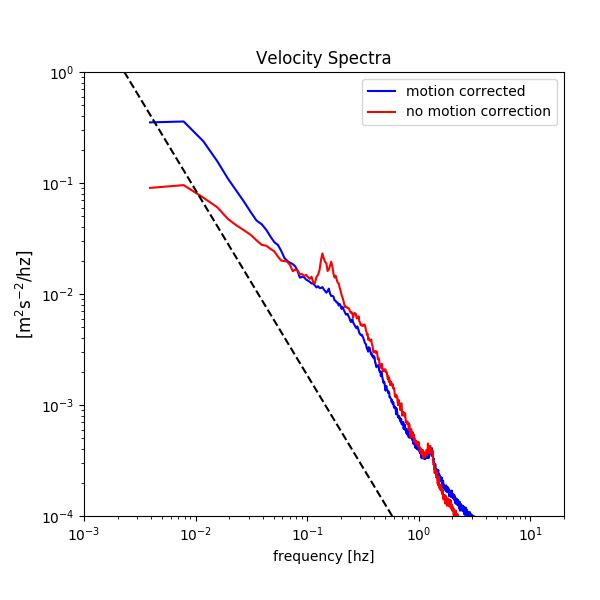

CPU times: user 3.81 s, sys: 585 ms, total: 4.4 s
Wall time: 4.49 s


In [25]:
%%time
%matplotlib nbagg
# Average the data and compute turbulence statistics
dat_bin = avm.calc_turbulence(dat, n_bin=19200,
                                n_fft=4096)
dat_cln_bin = avm.calc_turbulence(dat_cln, n_bin=19200,
                                    n_fft=4096)

fig2 = plt.figure(2, figsize=[6, 6])
fig2.clf()
ax = fig2.add_axes([.14, .14, .8, .74])

ax.loglog(dat_bin.freq, dat_bin.Suu_hz.mean(0),
            'b-', label='motion corrected')
ax.loglog(dat_cln_bin.freq, dat_cln_bin.Suu_hz.mean(0),
            'r-', label='no motion correction')

ax.set_xlim([1e-3, 20])
ax.set_ylim([1e-4, 1])
ax.set_xlabel('frequency [hz]')
ax.set_ylabel('$\mathrm{[m^2s^{-2}/hz]}$', size='large')

f_tmp = np.logspace(-3, 1)
ax.plot(f_tmp, 4e-5 * f_tmp ** (-5. / 3), 'k--')

ax.set_title('Velocity Spectra')
ax.legend()

plt.show()

### Turbulent Kinetic Energy Plot:

<IPython.core.display.Javascript object>


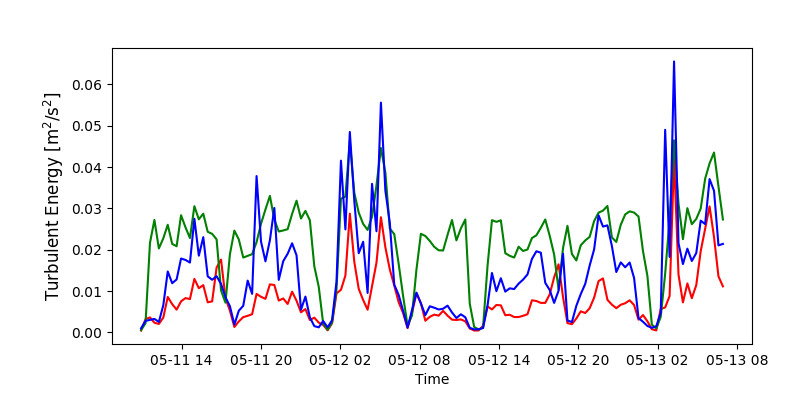

CPU times: user 93.5 ms, sys: 13.6 ms, total: 107 ms
Wall time: 136 ms


In [29]:
%%time
%matplotlib nbagg
fig = plt.figure(1, figsize=[8, 4])
fig.clf()
ax = fig.add_axes([.14, .14, .8, .74])

# first, convert the num_time to date_time, and plot this versus dat_raw.u
date_time = dt.num2date(dat_cln_bin.mpltime)

# plot the data
ax.plot(date_time, dat_cln_bin.upup_, 'r-', rasterized=True)
ax.plot(date_time, dat_cln_bin.vpvp_, 'g-', rasterized=True)
ax.plot(date_time, dat_cln_bin.wpwp_, 'b-', rasterized=True)

# label axes
ax.set_xlabel('Time')
ax.set_ylabel('Turbulent Energy $\mathrm{[m^2/s^2]}$', size='large')

plt.show()

### Reynold's Stress Plot:

<IPython.core.display.Javascript object>


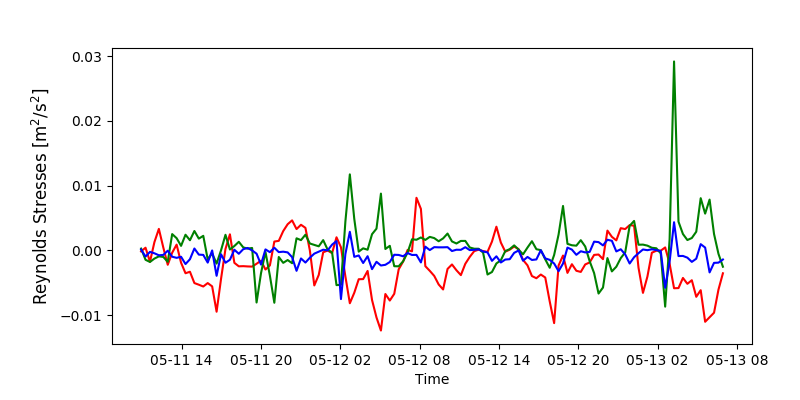

CPU times: user 96.5 ms, sys: 16.9 ms, total: 113 ms
Wall time: 227 ms


In [28]:
%%time
%matplotlib nbagg
fig = plt.figure(1, figsize=[8, 4])
fig.clf()
ax = fig.add_axes([.14, .14, .8, .74])

# first, convert the num_time to date_time, and plot this versus dat_raw.u
date_time = dt.num2date(dat_cln_bin.mpltime)

# plot the data
ax.plot(date_time, dat_cln_bin.upvp_, 'r-', rasterized=True)
ax.plot(date_time, dat_cln_bin.upwp_, 'g-', rasterized=True)
ax.plot(date_time, dat_cln_bin.vpwp_, 'b-', rasterized=True)

# label axes
ax.set_xlabel('Time')
ax.set_ylabel('Reynolds Stresses $\mathrm{[m^2/s^2]}$', size='large')

plt.show()